## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from cdd import CDD


In [2]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')

In [3]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)

## DAR

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 256)
        self.relu = nn.ELU()
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 256)
        self.h4 = nn.Linear(256,256)
        self.reg = nn.Linear(256, 1)
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        
        
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop1(h1_x)
        h1_x = self.h4(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop2(h1_x)
        h1_x = self.reg(h1_x)

        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h4(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}

### Pretrained

In [4]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_loss = 1000
for epoch in range(10000):
    optimizer.zero_grad()

    model_output_s = model.output(x_s)
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']



    # mse loss
    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s)
    y_s_mse.backward()
    if epoch % 100 == 0:
        print(f"Epoch : {epoch}, total_loss = {y_s_mse}")
    optimizer.step()
    val_loss = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
    if best_loss > val_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        print(f"Saving... val mse{val_loss}")

torch.save(best_model, "./best_pretrained_model.pt")

NameError: name 'Net' is not defined

### DA

In [5]:
model = torch.load("./best_pretrained_model.pt")
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

model_output_t_labeled = model.output(x_t_labeled)
latent_x_t_labeled = model_output_t_labeled['f_x']
y_t_labeled_hat = model_output_t_labeled['output']

model_output_t = model.output(x_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']

# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")

source mse : 0.0006118146702647209, labeled target mse : 1.9264698028564453, target mse : 1.9639837741851807


In [6]:
class ABS(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(ABS, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.abs(self.weights)
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

In [8]:
class ABS_RELU_NN(nn.Module):
    def __init__(self):
        super(ABS_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 32
        hidden_sizes = [self._num_units] + [32,32]
        layers = []
        layers.append(ABS(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(ABS(in_features, out_features))
        layers.append(ABS(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)

    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.3,0.3] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

    def output(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.3,0.3] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        output1 = outputs
        outputs = self.model[-1](outputs)
        return {'f_x':output1, 'output':outputs}

In [9]:
mapper = ABS_RELU_NN()
optimizer = optim.Adam(mapper.parameters(), lr=0.001)
best_mapper = copy.deepcopy(mapper)
best_loss = 1000
loss_list = []
bn = len(x_t_labeled)
for epoch in range(20000):
    optimizer.zero_grad()

    latent_x_s = x_s
    
    mapper_output_t_labeled = mapper.output(x_t_labeled)
    latent_x_t_labeled = mapper_output_t_labeled['output']
    
    
    # source latent에서 batch 추출
    batch_latent_x_s_index = torch.randperm(latent_x_s.size(0))[:bn]
    batch_latent_x_s = latent_x_s[batch_latent_x_s_index]


    # cdd loss
    feats_toalign_S = [batch_latent_x_s, torch.tensor([1]).repeat(len(batch_latent_x_s),1)]
    feats_toalign_T = [latent_x_t_labeled, torch.tensor([1]).repeat(len(latent_x_t_labeled),1)]
    cdd = CDD(kernel_num=(10,10), kernel_mul=(2,2), num_layers=2, num_classes=1, intra_only=True)
    cdd_loss = cdd.forward(feats_toalign_S, feats_toalign_T, [bn], [bn])['cdd']

    # ns loss
    epsilon_k = 5

    f_s_vector = latent_x_s
    f_t_vector = latent_x_t_labeled

    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=epsilon_k)
    knn.fit(y_s, np.array(range(len(y_s))))
    total_ns_loss = 0
    for i in range(bn):
        best_dist = 1000
        error = 0
        neighbors = knn.kneighbors(y_t_labeled[i].reshape(-1,1))[1][0].tolist()
        for index_i in neighbors:
            temp_f_dist = torch.abs(f_t_vector[i] - f_s_vector[index_i]).norm()
            temp_y_dist = torch.abs(y_t_labeled[i] - y_s[index_i]).norm()
            if best_dist > temp_f_dist + temp_y_dist:
                best_dist = temp_f_dist + temp_y_dist
                error = temp_f_dist
        total_ns_loss += error
    ns_loss = total_ns_loss / bn

    total_loss = cdd_loss + ns_loss
    
    if best_loss > total_loss:
        best_loss = total_loss
        best_mapper = copy.deepcopy(mapper)
    total_loss.backward()

    loss_list.append(total_loss.item())
    if epoch % 100 == 0:
        print(f"Epoch : {epoch}, total_loss = {np.mean(np.array(loss_list))}")
        loss_list = []
    optimizer.step()

Epoch : 0, total_loss = 164.7540283203125
Epoch : 100, total_loss = 234.88936279296874
Epoch : 200, total_loss = 268.2622401428223
Epoch : 300, total_loss = 79.04461505889893
Epoch : 400, total_loss = 29.17445301055908
Epoch : 500, total_loss = 14.837729110717774
Epoch : 600, total_loss = 9.393387522697449
Epoch : 700, total_loss = 6.626493144035339
Epoch : 800, total_loss = 5.858890027999878
Epoch : 900, total_loss = 5.097076909542084
Epoch : 1000, total_loss = 4.082974944114685
Epoch : 1100, total_loss = 3.2594750332832336
Epoch : 1200, total_loss = 2.6366140460968017
Epoch : 1300, total_loss = 2.2773504626750944
Epoch : 1400, total_loss = 2.028265768289566
Epoch : 1500, total_loss = 1.7059608733654021
Epoch : 1600, total_loss = 1.4656731057167054
Epoch : 1700, total_loss = 1.4499942672252655
Epoch : 1800, total_loss = 1.2734180772304535
Epoch : 1900, total_loss = 1.2689048755168915
Epoch : 2000, total_loss = 1.1150662410259247
Epoch : 2100, total_loss = 1.1538715615868569
Epoch : 22

KeyboardInterrupt: 

In [10]:
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

f_t_labeled = best_mapper.output(x_t_labeled)['output']
model_output_t_labeled = model.output(f_t_labeled)
latent_x_t_labeled = model_output_t_labeled['f_x']
y_t_labeled_hat = model_output_t_labeled['output']

f_t = best_mapper.output(x_t)['output']
model_output_t = model.output(f_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']

# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)
y_t_true_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_true_mse}")

source mse : 0.0006118146702647209, labeled target mse : 10.46082878112793, target mse : 10.453014373779297


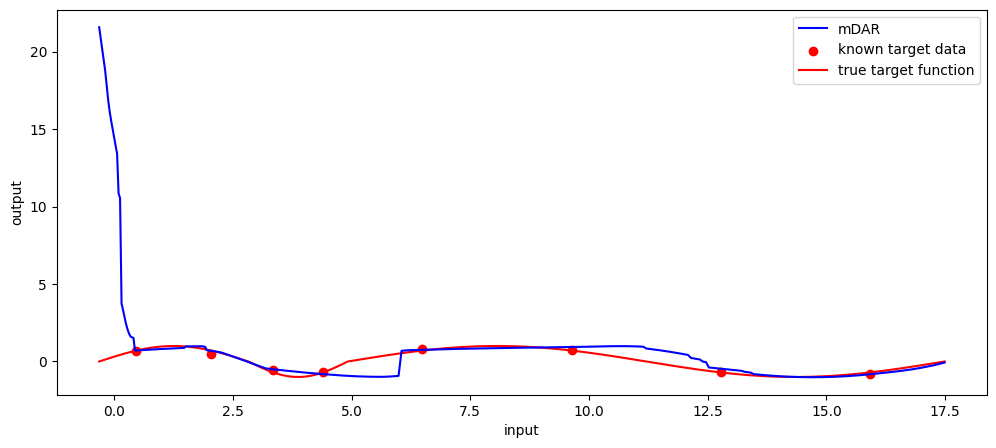

In [11]:
plt.figure(figsize=(12,5))
plt.plot(x_t, y_t_hat.detach().numpy(), c='blue', label='mDAR', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()